In [1]:
!pip install mediapipe

In [2]:
!pip install opencv-python

In [3]:
!pip install openface-test

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import numpy as np
import os
from glob import glob
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from collections import Counter

print("Libraries loaded")

Libraries loaded


In [6]:
class Config:

    CSV_DIR = '/content/drive/MyDrive/processed_videos'
    SAVE_DIR = '/content/drive/MyDrive/emotion_models'

    LANDMARK_FEATURES = []
    for i in range(26):
        LANDMARK_FEATURES.append(f'landmark_{i}_x')
        LANDMARK_FEATURES.append(f'landmark_{i}_y')

    CURRENT_FEATURES = [
        'gaze_yaw', 'gaze_pitch',
        'au_shape_dim1', 'au_shape_dim2', 'au_shape_dim3',
        'au_shape_dim4', 'au_shape_dim5', 'au_shape_dim6',
        'au_shape_dim7', 'au_shape_dim8'
    ]

    HOLDOUT_SIZE = 0.10  # 10% holdout for final testing
    VAL_SIZE = 0.15      # 15% of remaining 90% for validation (~13.5% of total)
    RANDOM_STATE = 42

    TEST_SIZE = 0.2
    VAL_SIZE = 0.1
    RANDOM_STATE = 42

    EMOTIONS = ['happy', 'sad', 'angry', 'surprise', 'neutral', 'fear', 'disgust']

config = Config()
print(f"Configuration loaded")
print(f"CSV Directory: {config.CSV_DIR}")
print(f"Save Directory: {config.SAVE_DIR}")
print(f"Features: {len(config.CURRENT_FEATURES)} ({', '.join(config.CURRENT_FEATURES[:3])}...)")

Configuration loaded
CSV Directory: /content/drive/MyDrive/processed_videos
Save Directory: /content/drive/MyDrive/emotion_models
Features: 10 (gaze_yaw, gaze_pitch, au_shape_dim1...)


In [7]:
class DataLoader:

    def __init__(self, csv_dir, feature_columns):
        self.csv_dir = csv_dir
        self.feature_columns = feature_columns

    def extract_emotion_from_filename(self, filename):
        base = os.path.basename(filename).lower()
        base = base.replace('_processed.csv', '')

        for emotion in config.EMOTIONS:
            if emotion in base:
                return emotion

        return None

    def load_all_csvs(self):
        csv_files = glob(f'{self.csv_dir}/*_processed.csv')

        if len(csv_files) == 0:
            csv_files = glob(f'{self.csv_dir}/*.csv')

        print(f"\n{'='*70}")
        print(f"LOADING DATA FROM {len(csv_files)} CSV FILES")
        print(f"{'='*70}\n")

        all_data = []
        all_labels = []
        file_stats = []

        for csv_file in csv_files:
            emotion = self.extract_emotion_from_filename(csv_file)

            if emotion is None:
                print(f"Skipping {os.path.basename(csv_file)} - no emotion detected")
                continue

            try:
                df = pd.read_csv(csv_file)

                if len(df) == 0:
                    print(f"Skipping {os.path.basename(csv_file)} - empty")
                    continue

                missing_cols = [col for col in self.feature_columns if col not in df.columns]
                if missing_cols:
                    print(f"Skipping {os.path.basename(csv_file)} - missing: {missing_cols}")
                    continue

                features = df[self.feature_columns].values

                valid_mask = ~np.any(np.isnan(features) | np.isinf(features), axis=1)
                features = features[valid_mask]

                if len(features) == 0:
                    print(f"Skipping {os.path.basename(csv_file)} - no valid data")
                    continue

                all_data.append(features)
                all_labels.extend([emotion] * len(features))

                file_stats.append({
                    'file': os.path.basename(csv_file),
                    'emotion': emotion,
                    'frames': len(features)
                })

                print(f"M {os.path.basename(csv_file):40s} → {emotion:10s} ({len(features):5d} frames)")

            except Exception as e:
                print(f" Error loading {os.path.basename(csv_file)}: {e}")

        if not all_data:
            print("\n No data loaded!")
            return None, None, None

        X = np.vstack(all_data)
        y = np.array(all_labels)

        print(f"\n{'='*70}")
        print("DATASET SUMMARY")
        print(f"{'='*70}")
        print(f"Total frames: {len(y):,}")
        print(f"Feature dimensions: {X.shape}")
        print(f"Features per frame: {X.shape[1]}")

        emotion_counts = Counter(y)
        print(f"\n Emotion Distribution:")
        for emotion in sorted(emotion_counts.keys()):
            count = emotion_counts[emotion]
            percentage = (count / len(y)) * 100
            print(f"  {emotion:12s}: {count:6,d} frames ({percentage:5.1f}%)")

        return X, y, file_stats

# Load data
loader = DataLoader(config.CSV_DIR, config.CURRENT_FEATURES)
X, y, file_stats = loader.load_all_csvs()


LOADING DATA FROM 280 CSV FILES

M keshia_angry_1_processed.csv             → angry      (  197 frames)
M keshia_angry_2_processed.csv             → angry      (  174 frames)
M keshia_angry_3_processed.csv             → angry      (  156 frames)
M keshia_angry_4_processed.csv             → angry      (  189 frames)
M keshia_angry_5_processed.csv             → angry      (  220 frames)
M keshia_angry_6_processed.csv             → angry      (  150 frames)
M keshia_angry_7_processed.csv             → angry      (  174 frames)
M keshia_angry_8_processed.csv             → angry      (  183 frames)
M keshia_angry_9_processed.csv             → angry      (  172 frames)
M keshia_angry_10_processed.csv            → angry      (  195 frames)
M keshia_happy_1_processed.csv             → happy      (  305 frames)
M keshia_happy_2_processed.csv             → happy      (  230 frames)
M keshia_happy_3_processed.csv             → happy      (  257 frames)
M keshia_happy_4_processed.csv             

In [8]:
if X is not None:

    feature_stats = pd.DataFrame({
        'Feature': config.CURRENT_FEATURES,
        'Mean': np.mean(X, axis=0),
        'Std': np.std(X, axis=0),
        'Min': np.min(X, axis=0),
        'Max': np.max(X, axis=0)
    })
    print(feature_stats.to_string(index=False))

    emotion_counts = Counter(y)
    min_count = min(emotion_counts.values())
    max_count = max(emotion_counts.values())
    imbalance_ratio = max_count / min_count

    print(f"\n Class Balance:")
    print(f"  Imbalance ratio: {imbalance_ratio:.2f}x")
    if imbalance_ratio > 3:
        print("High class imbalance - consider data augmentation or class weights")
    elif imbalance_ratio > 2:
        print("Moderate class imbalance - monitor per-class performance")
    else:
        print("Classes are reasonably balanced")

      Feature      Mean      Std       Min      Max
     gaze_yaw -0.256334 0.168620 -1.919312 0.058956
   gaze_pitch -0.043017 0.233185 -2.155140 0.398896
au_shape_dim1  0.193715 0.330152  0.000000 0.998794
au_shape_dim2  0.045182 0.182994  0.000000 0.997952
au_shape_dim3  0.264626 0.393767  0.000000 0.999731
au_shape_dim4  0.072877 0.195028  0.000000 0.998740
au_shape_dim5  0.094527 0.234962  0.000000 0.998332
au_shape_dim6  0.140268 0.301140  0.000000 0.999475
au_shape_dim7  0.506691 0.455735  0.000000 0.999252
au_shape_dim8  0.179370 0.328152  0.000000 0.999508

 Class Balance:
  Imbalance ratio: 1.09x
Classes are reasonably balanced


In [9]:
if X is not None:
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    print(f"Encoded emotions: {label_encoder.classes_}")

    min_samples = np.min(np.bincount(y_encoded))
    print(f"Minimum samples per class: {min_samples}")

    if min_samples < 2:
        print("\n ERROR: Need at least 2 samples per emotion for train/test split!")
        print("Some emotions don't have enough data")
    else:
        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y_encoded,
            test_size=config.TEST_SIZE + config.VAL_SIZE,
            stratify=y_encoded,
            random_state=config.RANDOM_STATE
        )

        val_ratio = config.VAL_SIZE / (config.TEST_SIZE + config.VAL_SIZE)
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp,
            test_size=1-val_ratio,
            stratify=y_temp,
            random_state=config.RANDOM_STATE
        )

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)

        print(f"\n Data split complete:")
        print(f"  Training:   {len(X_train):6,d} samples ({len(X_train)/len(X)*100:.1f}%)")
        print(f"  Validation: {len(X_val):6,d} samples ({len(X_val)/len(X)*100:.1f}%)")
        print(f"  Test:       {len(X_test):6,d} samples ({len(X_test)/len(X)*100:.1f}%)")
        print(f"\n Features normalized (StandardScaler)")


Encoded emotions: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
Minimum samples per class: 8752

 Data split complete:
  Training:   44,267 samples (70.0%)
  Validation:  6,324 samples (10.0%)
  Test:       12,649 samples (20.0%)

 Features normalized (StandardScaler)


In [10]:
if X is not None and min_samples >= 2:
    print(f"\n{'='*70}")
    print("MODEL TRAINING")
    print(f"{'='*70}")

    models = {
        'Random Forest': RandomForestClassifier(
            n_estimators=200,
            max_depth=25,
            min_samples_split=5,
            random_state=config.RANDOM_STATE,
            n_jobs=-1
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            random_state=config.RANDOM_STATE
        ),
        'SVM': SVC(
            kernel='rbf',
            C=10,
            gamma='scale',
            random_state=config.RANDOM_STATE
        ),
        'MLP': MLPClassifier(
            hidden_layer_sizes=(128, 64, 32),
            max_iter=500,
            random_state=config.RANDOM_STATE,
            early_stopping=True
        )
    }

    results = {}

    for name, model in models.items():
        print(f"\n{'='*70}")
        print(f"Training: {name}")
        print(f"{'='*70}")

        model.fit(X_train_scaled, y_train)

        train_acc = accuracy_score(y_train, model.predict(X_train_scaled))
        val_acc = accuracy_score(y_val, model.predict(X_val_scaled))
        test_acc = accuracy_score(y_test, model.predict(X_test_scaled))

        results[name] = {
            'model': model,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'test_acc': test_acc
        }

        print(f"Train Accuracy: {train_acc:.4f}")
        print(f"  Val Accuracy:   {val_acc:.4f}")
        print(f"  Test Accuracy:  {test_acc:.4f}")

        if train_acc - test_acc > 0.15:
            print(f"Possible overfitting (train-test gap: {train_acc-test_acc:.4f})")

    best_model_name = max(results, key=lambda x: results[x]['test_acc'])
    best_model = results[best_model_name]['model']
    best_test_acc = results[best_model_name]['test_acc']

    print(f"\n{'='*70}")
    print(f" BEST MODEL: {best_model_name}")
    print(f"{'='*70}")
    print(f"Test Accuracy: {best_test_acc:.4f}")


MODEL TRAINING

Training: Random Forest
Train Accuracy: 0.9796
  Val Accuracy:   0.8297
  Test Accuracy:  0.8221
Possible overfitting (train-test gap: 0.1575)

Training: Gradient Boosting
Train Accuracy: 0.8227
  Val Accuracy:   0.7726
  Test Accuracy:  0.7669

Training: SVM
Train Accuracy: 0.6958
  Val Accuracy:   0.6820
  Test Accuracy:  0.6789

Training: MLP
Train Accuracy: 0.7487
  Val Accuracy:   0.7245
  Test Accuracy:  0.7233

 BEST MODEL: Random Forest
Test Accuracy: 0.8221



DETAILED EVALUATION

 Classification Report:
              precision    recall  f1-score   support

       angry       0.83      0.80      0.81      1750
     disgust       0.80      0.81      0.80      1766
        fear       0.83      0.73      0.78      1818
       happy       0.92      0.92      0.92      1807
     neutral       0.74      0.81      0.78      1779
         sad       0.78      0.82      0.80      1917
    surprise       0.86      0.87      0.86      1812

    accuracy                           0.82     12649
   macro avg       0.82      0.82      0.82     12649
weighted avg       0.82      0.82      0.82     12649



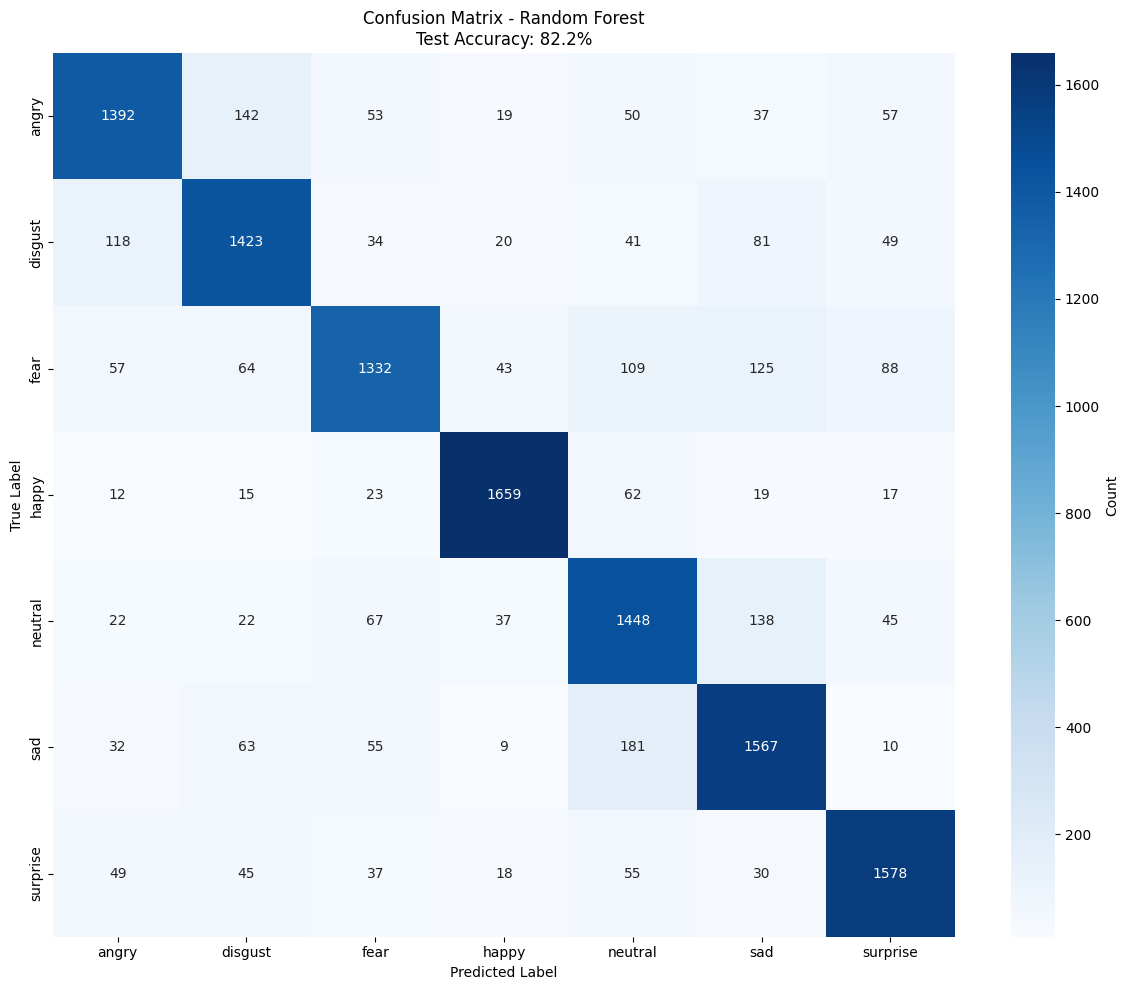


 Per-Class Accuracy:
  angry       : 0.7954 (1750 samples)
  disgust     : 0.8058 (1766 samples)
  fear        : 0.7327 (1818 samples)
  happy       : 0.9181 (1807 samples)
  neutral     : 0.8139 (1779 samples)
  sad         : 0.8174 (1917 samples)
  surprise    : 0.8709 (1812 samples)


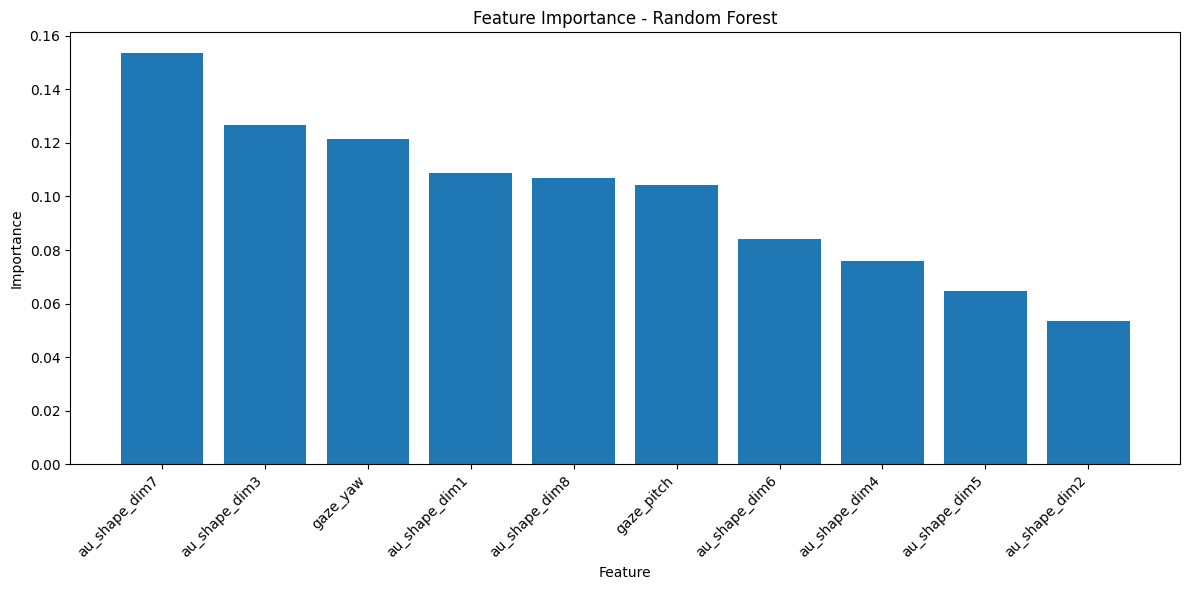


 Top 5 Most Important Features:
  1. au_shape_dim7  : 0.1537
  2. au_shape_dim3  : 0.1268
  3. gaze_yaw       : 0.1216
  4. au_shape_dim1  : 0.1087
  5. au_shape_dim8  : 0.1070


In [11]:
if X is not None and min_samples >= 2:
    print(f"\n{'='*70}")
    print("DETAILED EVALUATION")
    print(f"{'='*70}")

    y_pred = best_model.predict(X_test_scaled)

    print(f"\n Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {best_model_name}\nTest Accuracy: {best_test_acc:.1%}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    print(f"\n Per-Class Accuracy:")
    for i, emotion in enumerate(label_encoder.classes_):
        mask = (y_test == i)
        if mask.sum() > 0:
            class_acc = accuracy_score(y_test[mask], y_pred[mask])
            print(f"  {emotion:12s}: {class_acc:.4f} ({mask.sum()} samples)")

    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(12, 6))
        plt.bar(range(len(importances)), importances[indices])
        plt.xticks(range(len(importances)),
                   [config.CURRENT_FEATURES[i] for i in indices],
                   rotation=45, ha='right')
        plt.title(f'Feature Importance - {best_model_name}')
        plt.xlabel('Feature')
        plt.ylabel('Importance')
        plt.tight_layout()
        plt.show()

        print(f"\n Top 5 Most Important Features:")
        for i in range(min(5, len(importances))):
            idx = indices[i]
            print(f"  {i+1}. {config.CURRENT_FEATURES[idx]:15s}: {importances[idx]:.4f}")


MODEL COMPARISON

            Model  Train Acc  Val Acc  Test Acc
    Random Forest   0.979624 0.829696  0.822120
Gradient Boosting   0.822690 0.772612  0.766938
              MLP   0.748707 0.724541  0.723298
              SVM   0.695823 0.682005  0.678947


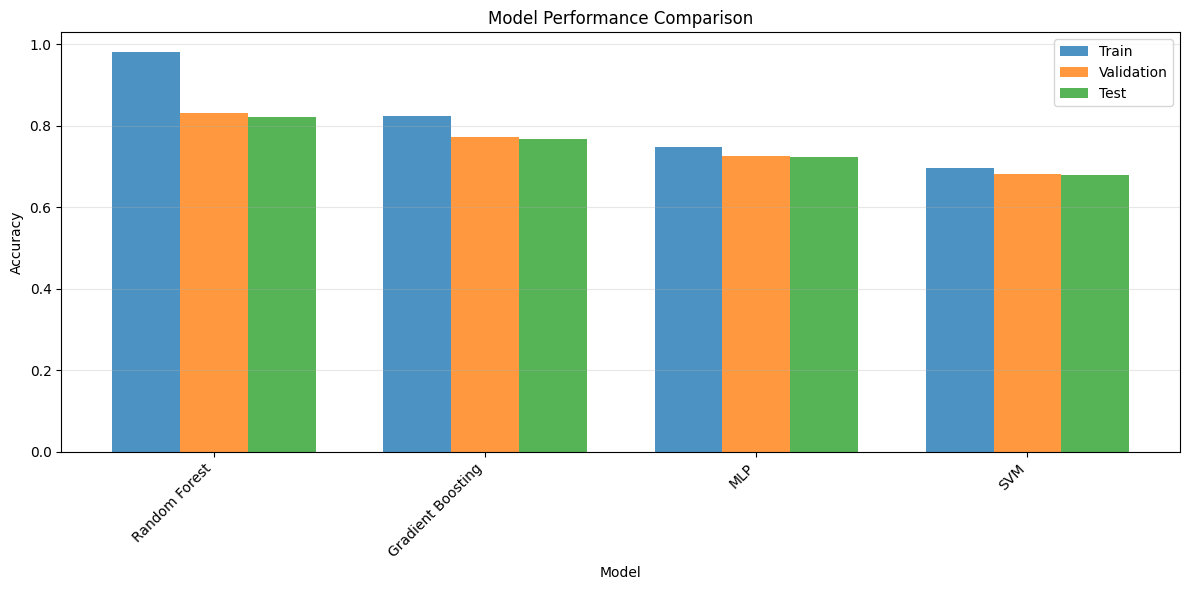

In [12]:
if X is not None and min_samples >= 2:
    print(f"\n{'='*70}")
    print("MODEL COMPARISON")
    print(f"{'='*70}")

    # Create comparison dataframe
    comparison_df = pd.DataFrame({
        'Model': list(results.keys()),
        'Train Acc': [results[m]['train_acc'] for m in results],
        'Val Acc': [results[m]['val_acc'] for m in results],
        'Test Acc': [results[m]['test_acc'] for m in results]
    })
    comparison_df = comparison_df.sort_values('Test Acc', ascending=False)

    print("\n" + comparison_df.to_string(index=False))

    # Visualize comparison
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(comparison_df))
    width = 0.25

    ax.bar(x - width, comparison_df['Train Acc'], width, label='Train', alpha=0.8)
    ax.bar(x, comparison_df['Val Acc'], width, label='Validation', alpha=0.8)
    ax.bar(x + width, comparison_df['Test Acc'], width, label='Test', alpha=0.8)

    ax.set_xlabel('Model')
    ax.set_ylabel('Accuracy')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [13]:
if X is not None and min_samples >= 2:
    os.makedirs(config.SAVE_DIR, exist_ok=True)

    print(f"\n{'='*70}")
    print("SAVING MODELS")
    print(f"{'='*70}")

    # Save best model
    joblib.dump(best_model, f'{config.SAVE_DIR}/best_model.pkl')
    print(f"✓ Best model saved: {best_model_name}")

    # Save all models
    for name, result in results.items():
        safe_name = name.lower().replace(' ', '_')
        joblib.dump(result['model'], f'{config.SAVE_DIR}/{safe_name}_model.pkl')
        print(f"✓ Saved: {name}")

    # Save preprocessors
    joblib.dump(scaler, f'{config.SAVE_DIR}/scaler.pkl')
    joblib.dump(label_encoder, f'{config.SAVE_DIR}/label_encoder.pkl')
    print(f"✓ Saved: Scaler and Label Encoder")

    # Save metadata
    metadata = {
        'best_model': best_model_name,
        'test_accuracy': float(best_test_acc),
        'features': config.CURRENT_FEATURES,
        'emotions': label_encoder.classes_.tolist(),
        'total_samples': len(X),
        'training_samples': len(X_train),
        'test_samples': len(X_test)
    }

    import json
    with open(f'{config.SAVE_DIR}/model_metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f"✓ Saved: Metadata")

    # Save raw data
    np.save(f'{config.SAVE_DIR}/X_features.npy', X)
    np.save(f'{config.SAVE_DIR}/y_labels.npy', y)
    print(f"✓ Saved: Raw data (backup)")

    print(f"\n All files saved to: {config.SAVE_DIR}")


SAVING MODELS
✓ Best model saved: Random Forest
✓ Saved: Random Forest
✓ Saved: Gradient Boosting
✓ Saved: SVM
✓ Saved: MLP
✓ Saved: Scaler and Label Encoder
✓ Saved: Metadata
✓ Saved: Raw data (backup)

 All files saved to: /content/drive/MyDrive/emotion_models
